In [1]:
import numpy as np
import gym
import tensorflow as tf
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv
from baselines.common.vec_env.dummy_vec_env import DummyVecEnv

learning_rate = 0.001

env_name = 'CartPole-v1'
environments_count = 42


# This code gets action and observation space sizes for 1D tasks
env = gym.make(env_name)
action_space = env.action_space.n if isinstance(env.action_space, gym.spaces.discrete.Discrete) else env.action_space.shape[0]
observation_space = env.observation_space.n if isinstance(env.observation_space, gym.spaces.discrete.Discrete) else env.observation_space.shape[0]


## Create environments vector

In [2]:
def make_env(env_id, seed):
    def _f():
        env = gym.make(env_id)
        env.seed(seed)
        
        # Desync environments
        env.reset()
        for i in range(int(env.spec.max_episode_steps*seed//environments_count)):
            env.step(env.action_space.sample())
        return env
    return _f

envs = [make_env(env_name, seed) for seed in range(environments_count)]
envs = DummyVecEnv(envs)

# observations = envs.reset()
# for t in range(100):
#     # print(envs.render(mode='human'))
#     actions = np.stack([envs.action_space.sample() for _ in range(nproc)])
#     observations, rewards, done, info = envs.step(actions)
    

C:\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Create model architecture

In [3]:
tf.reset_default_graph()

state_ph = tf.placeholder(tf.float32, shape=[None, observation_space])
l1 = tf.layers.dense(state_ph, units=32, activation=tf.nn.relu)
output_linear = tf.layers.dense(l1, units=action_space)

output = tf.nn.softmax(output_linear)
action_op = tf.squeeze(tf.multinomial(logits=output_linear,num_samples=1), axis=1)
#action_op = tf.expand_dims(tf.constant(1), axis=0)

output_log = tf.nn.log_softmax(output_linear)

weight_ph = tf.placeholder(shape=[None], dtype=tf.float32)
action_ph = tf.placeholder(shape=[None], dtype=tf.int32)


action_one_hot = tf.one_hot(action_ph, action_space)
responsible_output_log = tf.reduce_sum(output_log * action_one_hot, axis=1)
loss = -tf.reduce_mean(responsible_output_log * weight_ph)

optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
update = optimizer.minimize(loss)

W0718 19:25:36.510815  2888 deprecation.py:323] From <ipython-input-3-ac2fb8c5e269>:4: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0718 19:25:36.514803  2888 deprecation.py:506] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0718 19:25:36.794026  2888 deprecation.py:323] From <ipython-input-3-ac2fb8c5e269>:8: multinomial (from tensorflow.python.ops.random_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.random.categorical` instead.
W0718 19:25:36.853589  2888 deprecation.py:506] From C:\Anaconda3\lib\site-packages\tensorflow\python\training\rmsprop.

In [4]:
config = tf.ConfigProto(device_count={'GPU': 0})
sess = tf.Session(config=config)

sess.run(tf.local_variables_initializer())
sess.run(tf.global_variables_initializer())

# sess.run(loss, feed_dict={weight_ph: [0, 1, 2],
#                           action_ph: [1, 2, 3],
#                           state_ph: [[1,2], [1,2], [1,2]]})

In [5]:
def make_reward_to_go(reward):
    return np.cumsum(reward[::-1])[::-1]

make_reward_to_go(np.arange(1, 5))

array([10,  9,  7,  4], dtype=int32)

#TODO: подумать о последствиях слишком большого количества сэмплов в начале (решил рассинхронизацией)

In [6]:
def generate_batch(envs, batch_size, replay_buffer_size):
    envs_number = envs.num_envs
    #observations = envs.reset()
    observations = [[0 for i in range(observation_space)] for i in range(envs_number)]
    replay_buffer = np.empty((0,3), np.float32)
    
    # [state, action, weight] rollout lists for every environment instance
    rollouts = [np.empty((0, 3)) for i in range(envs_number)]

    while True:
        history = {'reward': []}
        replay_buffer = replay_buffer[batch_size:]
        
        # Main sampling cycle
        while len(replay_buffer) < replay_buffer_size:
            actions = sess.run(action_op, feed_dict={state_ph: observations})
            observations_old = observations
            observations, rewards, dones, _ = envs.step(actions)
            
            
            
            time_point = np.array(list(zip(observations_old, actions, rewards)))
            for i in range(envs_number):
                rollouts[i] = np.append(rollouts[i], [time_point[i]], axis=0) # Regular python append
            
            if dones.any():
                if dones.all():
                    print('WARNING: envs are in sync!!')
                
                done_indexes = np.arange(envs_number)[dones]
                for i in done_indexes:
                    #print(dones, i, len(rollouts[i][:, 2]))
                    history['reward'].append(rollouts[i][:, 2].sum())

                    rollouts[i][:, 2] = make_reward_to_go(rollouts[i][:, 2])
                    replay_buffer = np.append(replay_buffer, rollouts[i], axis=0)
                    rollouts[i] = np.empty((0, 3))
                #history['reward'] = [np.mean(history['reward'])]
        
        np.random.shuffle(replay_buffer)
        replay_buffer = replay_buffer[:replay_buffer_size] ### QUESTIONABLE
        yield replay_buffer[:batch_size], history

a = generate_batch(envs, 8, 64)
# Makes them of equal lenght
for i in range(10):
    next(a)
next(a)[0]

array([[array([ 0.13704354,  0.43969426, -0.15403824, -0.9375994 ], dtype=float32),
        0, 4.0],
       [array([ 0.03633925,  0.42485702,  0.01299288, -0.600554  ], dtype=float32),
        1, 18.0],
       [array([-0.11723114, -0.19652027,  0.18609506,  0.69680375], dtype=float32),
        0, 2.0],
       [array([ 0.00553979,  0.7907528 , -0.00345111, -1.1359961 ], dtype=float32),
        1, 11.0],
       [array([ 0.10748331, -0.3794983 , -0.15416692,  0.21993002], dtype=float32),
        1, 8.0],
       [array([-0.08633589, -0.57850754,  0.11681421,  1.0950931 ], dtype=float32),
        1, 6.0],
       [array([-0.00414837, -0.37744442,  0.00801333,  0.5642539 ], dtype=float32),
        1, 19.0],
       [array([ 0.09443948,  0.6213387 , -0.07060107, -0.9248802 ], dtype=float32),
        0, 13.0]], dtype=object)

In [7]:
from tqdm import tqdm_notebook

history = {'reward': [], 'loss': []}
batch_generator = generate_batch(envs,
                                 batch_size=128,
                                 replay_buffer_size=256)
# Makes them of equal lenght
for i in range(10):
    next(batch_generator)

for epoch in tqdm_notebook(range(10000)):
    batch, batch_history = next(batch_generator)
    history['reward'] += batch_history['reward']
    
#     if batch_history['reward'] and np.mean(batch_history['reward']) != -200:
#         print('DONE!!')
    
    #a, b, c, d, e, f = sess.run([action_ph, action_one_hot, output_linear, output_log, responsible_output_log, loss], feed_dict={state_ph: np.array(batch[:, 0].tolist()),
    #                            action_ph: batch[:, 1],
    #                            weight_ph: batch[:, 2]})
    #print(a[0], b[0], c[0], d[0], e[0], f)

    
    _, loss_ = sess.run([update, loss], feed_dict={state_ph: np.array(batch[:, 0].tolist()),
                                                    action_ph: batch[:, 1],
                                                    weight_ph: batch[:, 2]})
    history['loss'].append(loss_)


## Plot results

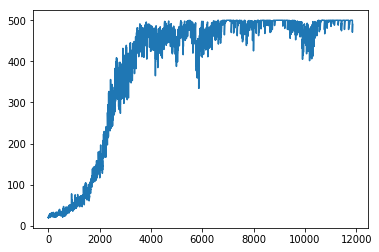

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# Moving average
def smoothen_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(np.arange(len(history['reward'])), smoothen_curve(history['reward']))

## Loss doesn’t measure performance

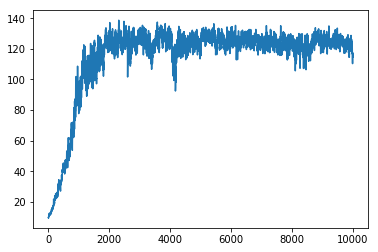

In [9]:
plt.plot(np.arange(len(history['loss'])), smoothen_curve(history['loss']))

## Our agent

In [10]:
observations = env.reset()

for i in range(1000):
    env.render()
    actions = sess.run(action_op, feed_dict={state_ph: [observations]})
    observations_old = observations
    observations, rewards, dones, _ = env.step(actions[0])
    
    if dones:
        observations = env.reset()
        print('Done')
    

Done
Done


## Random agent

In [11]:
observations = env.reset()

for i in range(1000):
    env.render()
    actions = [envs.action_space.sample() for i in range(envs.num_envs)]
    observations_old = observations
    observations, rewards, dones, _ = env.step(actions[0])
    
    if dones:
        observations = env.reset()
        print('Done')
    

Done
Done
Done
Done
Done
Done


KeyboardInterrupt: 